# Проект предсказания судьбы стартапов #

## Описание задачи ##

По данным о стартапах, функционировавших в период с 1970 по 2018 годы, и предсказать, какие из них закроются. Для каждого стартапа предскажите категориальное значение соответствующее прогнозу ['operating', 'closed'].

## Основные этапы выполнения проекта ##
- загрузка и ознакомление с данными,
- предварительная обработка,
- полноценный разведочный анализ,
- разработка новых синтетических признаков,
- проверка на мультиколлинеарность,
- Отбор финального набора обучающих признаков и подготовка данных для моделей,
- выбор и обучение моделей,
- итоговая оценка качества предсказания лучшей модели,
- анализ важности ее признаков,
- подготовка отчета по исследованию

### Загрузка и ознакомление с данными ###

In [1]:
# Импортируем нужные библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from catboost import CatBoostClassifier
from phik.report import plot_correlation_matrix

In [2]:
# Зададим константы для данной задачи
RANDOM_STATE = 10 # Для модели
TEST_SIZE = 0.25 # Для разделения на тренировочную и тестовую выборку
TOP_CATEROGY = 50 # Для выделения количества категорий для модели

In [3]:
# Путь к тренировочным данным
path = 'kaggle_startups_train_28062024.csv'

In [4]:
# Загружаем данные
if os.path.exists(path):
    df_train = pd.read_csv(path)
else:
    print('Такого файла нет')

In [5]:
df_train.head(3)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN


In [6]:
df_train.shape

(52516, 13)

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


#### Описание полей данных ####
- **name** - Название стартапа
- **category_list** - Список категорий, к которым относится стартап
- **funding_total_usd** - Общая сумма финансирования в USD
- **status** - Статус стартапа (закрыт или действующий) - **целевой признак**
- **country_code** - Код страны
- **state_code** - Код штата
- **region** - Регион
- **city** - Город
- **funding_rounds** - Количество раундов финансирования
- **founded_at** - Дата основания
- **first_funding_at** - Дата первого раунда финансирования
- **last_funding_at** - Дата последнего раунда финансирования
- **closed_at** - Дата закрытия стартапа (если применимо)

In [8]:
df_train.isna().sum()

name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5502
state_code            6763
region                6359
city                  6359
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64

Много пропусков. С ними разберемся на этапе подготовки данных для моделей

Данные успешно загружены. Данные соответствуют описанию задачи. В датафрейме находятся данные о 52516 стартапов. В данных есть целевой признак: статус стартапа. Много пропусков, у некоторых признаков более 10% пропусков

### Предварительная обработка ###

#### Проверка на наличие дубликатов ####

In [9]:
df_train.duplicated().sum()

0

In [10]:
df_train['name'].duplicated().sum()

0

Дубликатов в наборе данных нет

#### Изменение типов данных ####

In [11]:
df_train['founded_at'] = pd.to_datetime(
    df_train['founded_at'], format='%Y-%m-%d')

df_train['first_funding_at'] = pd.to_datetime(
    df_train['first_funding_at'], format='%Y-%m-%d')

df_train['last_funding_at'] = pd.to_datetime(
    df_train['last_funding_at'], format='%Y-%m-%d')

df_train['closed_at'] = pd.to_datetime(
    df_train['closed_at'], format='%Y-%m-%d')

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

Дубликатов нет. Поменяли тип данных у признаков founded_at, first_funding_at, last_funding_at, closed_at

### Полноценный разведочный анализ

In [13]:
# создадим функцию построения гистограммы и диаграммы размаха для количественных признаков
def build_graph(num_feature, name):
    plt.figure(figsize=(10,10))
    plt.subplot(2, 1, 1)
    df_train[num_feature].plot.kde(grid=True)
    plt.title("Гистограмма плотности частоты")
    plt.xlabel(name)
    plt.ylabel('Плотность частоты')

    plt.subplot(2, 1, 2)
    sns.boxplot(data=df_train, x=num_feature)
    plt.title("Диаграмма размаха")
    plt.xlabel(name)
    plt.show()  

#### Список категорий, к которым относится стартап

In [14]:
df_train['category_list'].value_counts(normalize=True).head(10)

category_list
Software               0.064075
Biotechnology          0.058041
E-Commerce             0.021258
Mobile                 0.018381
Clean Technology       0.017822
Curated Web            0.017043
Health Care            0.014865
Hardware + Software    0.014645
Games                  0.013606
Enterprise Software    0.013406
Name: proportion, dtype: float64

In [15]:
df_train['category_list'].nunique()

22105

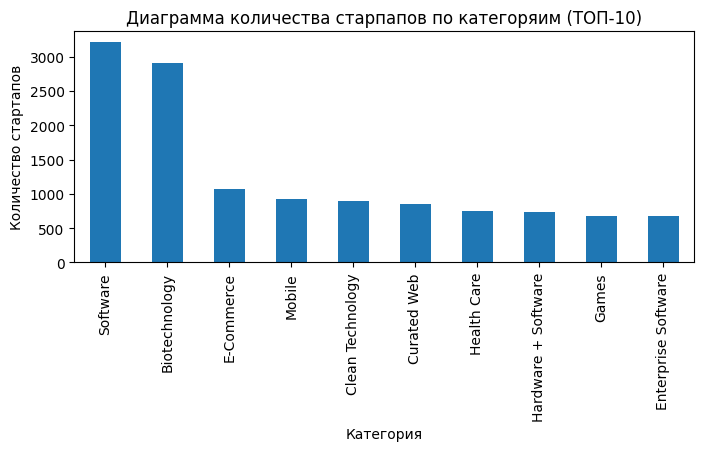

In [16]:
plt.figure(figsize=(8,3))
df_train["category_list"].value_counts().head(10).plot(kind='bar')
plt.title("Диаграмма количества старпапов по категоряим (ТОП-10)")
plt.xlabel('Категория')
plt.ylabel('Количество стартапов')
plt.show()

In [17]:
# Вычислим значение сколько процентов открытых стартапов из общего набора данных
# Это значение будем отображать на диаграммах ниже
mean_status = df_train['status'].value_counts(normalize=True)[0]

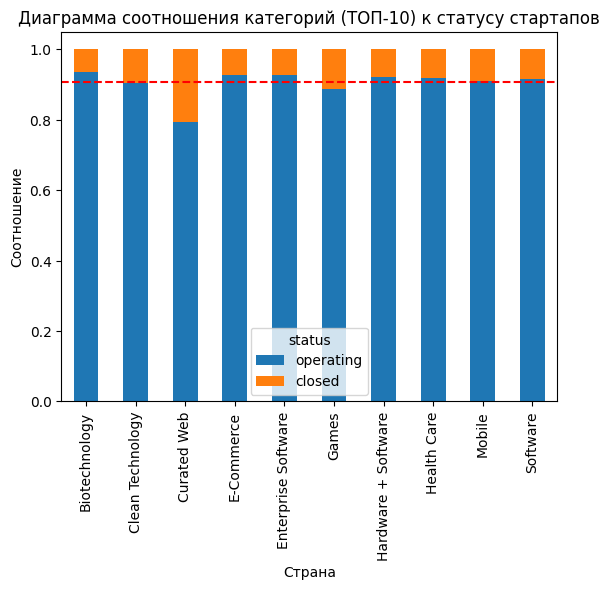

In [18]:
# Построим диаграмму соотношения категорий (из числа TOP 10 по количеству стартапов в них) к статусам стартапов
df_tmp = df_train[df_train['category_list'].isin(
    df_train['category_list'].value_counts().head(10).
    index.to_list())]
pd.crosstab(
     [df_tmp['category_list']],
     df_tmp['status'],
     normalize = 'index').head(10)[['operating', 'closed']].plot.bar(stacked=True)
plt.title("Диаграмма соотношения категорий (ТОП-10) к статусу стартапов")
plt.xlabel("Страна")
plt.ylabel("Соотношение")
plt.axhline(mean_status, color='r', linestyle='--')
plt.show()

На диаграмме видно, что стартапы категории 'Curated Web' чаще закрываются по сравнению со стартапами других категорий из ТОП-10

Список категорий, к которым относится стартап, большой. У многих записей категории перечисленны через разделитель '|'. Попробуем список разделить на отдельные категории на этапе разработки новых синтетических признаков и выбрать из них ТОП-n признаков (значение n берем из TOP_CATEROGY)

#### Общая сумма финансирования в USD

In [19]:
df_train['funding_total_usd'].describe()

count    4.244700e+04
mean     1.824748e+07
std      1.871173e+08
min      1.000000e+00
25%      3.360275e+05
50%      2.000000e+06
75%      1.000000e+07
max      3.007950e+10
Name: funding_total_usd, dtype: float64

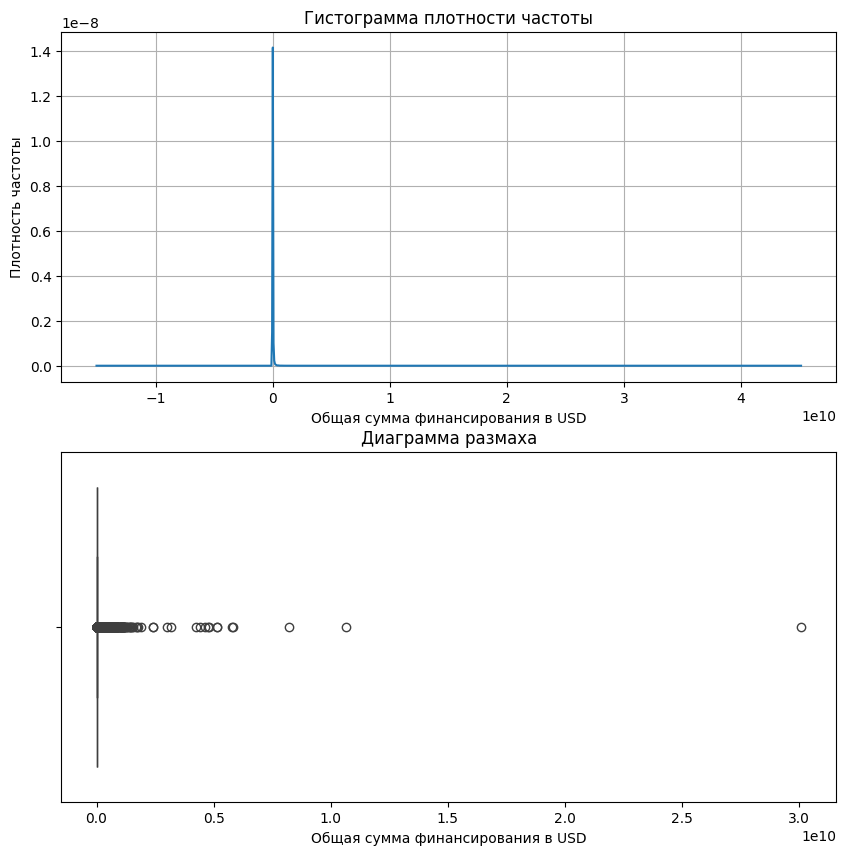

In [20]:
build_graph('funding_total_usd', 'Общая сумма финансирования в USD')

Медиана равно 2 млн., среднее равно 18 млн., максимальное значение равно 30 млрд.

#### Код страны

In [21]:
df_train['country_code'].nunique()

134

In [22]:
# TOP-10
df_train['country_code'].value_counts(normalize=True).head(10)

country_code
USA    0.631769
GBR    0.062216
CAN    0.032756
IND    0.027141
CHN    0.026375
FRA    0.019484
DEU    0.017739
ISR    0.016314
ESP    0.012911
NLD    0.008083
Name: proportion, dtype: float64

In [23]:
df_train['country_code'].isna().sum()

5502

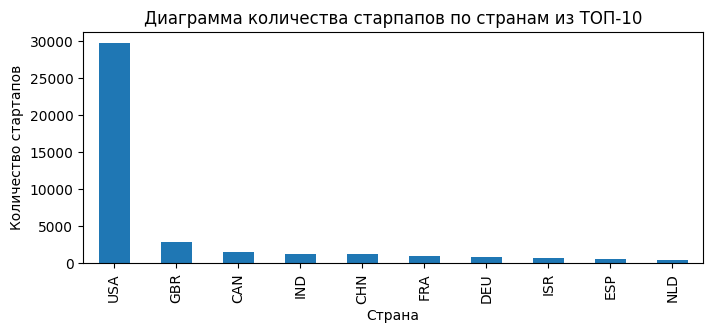

In [24]:
plt.figure(figsize=(8,3))
df_train["country_code"].value_counts().head(10).plot(kind='bar')
plt.title("Диаграмма количества старпапов по странам из ТОП-10")
plt.xlabel('Страна')
plt.ylabel('Количество стартапов')
plt.show()

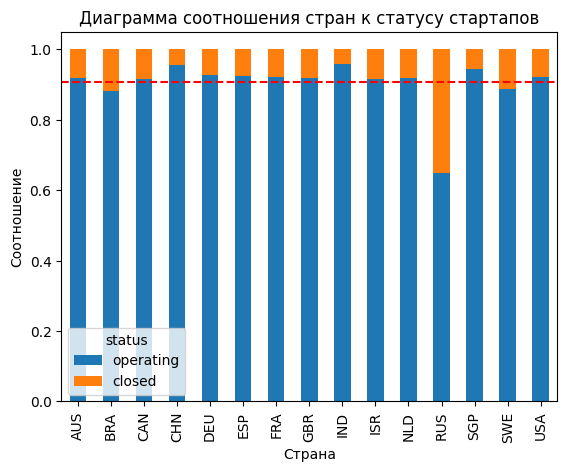

In [25]:
# Построим диаграмму соотношения стран (из числа TOP 10 по количеству стартапов в них) к статусам стартапов
df_tmp = df_train[df_train['country_code'].isin(
    df_train['country_code'].value_counts().head(15).
    index.to_list())]
pd.crosstab(
     [df_tmp['country_code']],
     df_tmp['status'],
     normalize = 'index').head(15)[['operating', 'closed']].plot.bar(stacked = True)
plt.title("Диаграмма соотношения стран к статусу стартапов")
plt.xlabel("Страна")
plt.ylabel("Соотношение")
plt.axhline(mean_status, color='r', linestyle='--')
plt.show()

В датафрейме 134 страны, больше половины из них в USA, более 5 тыс. пропусков. У стартапов из России соотношение к статусу стартапов отличается по сравнению со стартапами из других стран, поэтому на этапе разработки новых признаков стартапы из России выделим в отдельный признак.

#### Код штата

In [26]:
df_train['state_code'].nunique()

300

In [27]:
# TOP-10
df_train['state_code'].value_counts(normalize=True).head(10)

state_code
CA    0.223351
NY    0.068017
MA    0.044150
TX    0.034140
H9    0.033003
7     0.023933
FL    0.022687
WA    0.021791
2     0.019955
IL    0.018775
Name: proportion, dtype: float64

In [28]:
df_train['state_code'].isnull().sum()

6763

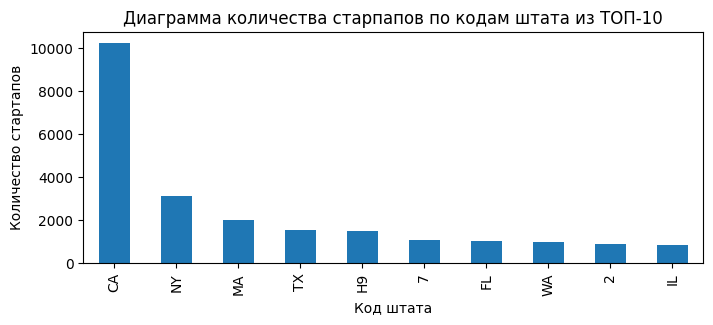

In [29]:
plt.figure(figsize=(8,3))
df_train["state_code"].value_counts().head(10).plot(kind='bar')
plt.title("Диаграмма количества старпапов по кодам штата из ТОП-10")
plt.xlabel('Код штата')
plt.ylabel('Количество стартапов')
plt.show()

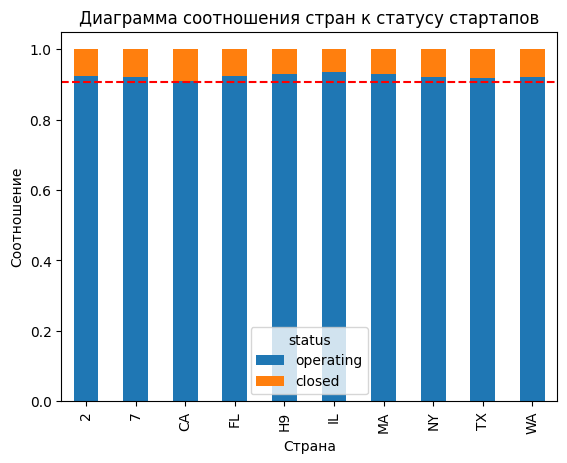

In [30]:
df_tmp = df_train[df_train['state_code'].isin(
    df_train['state_code'].value_counts().head(10).
    index.to_list())]
pd.crosstab(
     [df_tmp['state_code']],
     df_tmp['status'],
     normalize = 'index').head(10)[['operating', 'closed']].plot.bar(stacked = True)
plt.title("Диаграмма соотношения стран к статусу стартапов")
plt.xlabel("Страна")
plt.ylabel("Соотношение")
plt.axhline(mean_status, color='r', linestyle='--')
plt.show()

Больше всего старпапов (22%) из штата CA (Калифорния). Вероятнее всего из Силиконовой долины. Более 6 тыс. пропусков. Соотношение штатов из ТОП-10 к статусу стартапов примерно одинаковое.

#### Регион

In [31]:
df_train['region'].nunique()

1036

In [32]:
# TOP-10
df_train['region'].value_counts(normalize=True).head(10)

region
SF Bay Area         0.151006
New York City       0.060143
Boston              0.040947
London              0.039864
Los Angeles         0.032779
Seattle             0.020690
Washington, D.C.    0.017700
Chicago             0.016856
San Diego           0.015231
Austin              0.014126
Name: proportion, dtype: float64

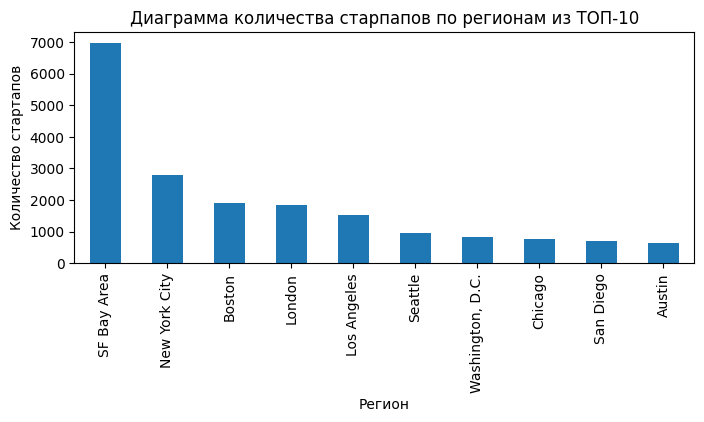

In [33]:
plt.figure(figsize=(8,3))
df_train["region"].value_counts().head(10).plot(kind='bar')
plt.title("Диаграмма количества старпапов по регионам из ТОП-10")
plt.xlabel('Регион')
plt.ylabel('Количество стартапов')
plt.show()

In [34]:
df_train['region'].isnull().sum()

6359

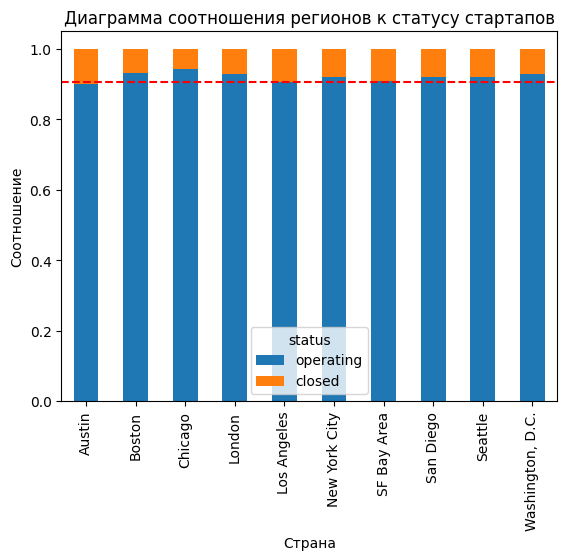

In [35]:
df_tmp = df_train[df_train['region'].isin(
    df_train['region'].value_counts().head(10).
    index.to_list())]
pd.crosstab(
     [df_tmp['region']],
     df_tmp['status'],
     normalize = 'index').head(10)[['operating', 'closed']].plot.bar(stacked = True)
plt.title("Диаграмма соотношения регионов к статусу стартапов")
plt.xlabel("Страна")
plt.ylabel("Соотношение")
plt.axhline(mean_status, color='r', linestyle='--')
plt.show()

Больше всего стартапов из региона SF Bay Area (там же находится Силиконовая долина). Более 6 тыс. пропусков. На диаграмме немного выделяется SF Bay Area.

#### Город

In [36]:
df_train['city'].nunique()

4477

In [37]:
df_train['city'].value_counts(normalize=True).head(10)

city
San Francisco    0.061182
New York         0.053860
London           0.032801
Austin           0.013194
Palo Alto        0.013151
Los Angeles      0.013086
Seattle          0.012826
Chicago          0.011829
Cambridge        0.011743
Boston           0.011006
Name: proportion, dtype: float64

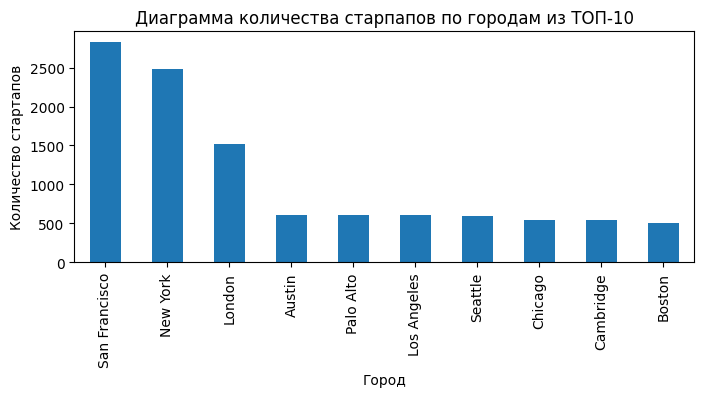

In [38]:
plt.figure(figsize=(8,3))
df_train["city"].value_counts().head(10).plot(kind='bar')
plt.title("Диаграмма количества старпапов по городам из ТОП-10")
plt.xlabel('Город')
plt.ylabel('Количество стартапов')
plt.show()

In [39]:
df_train['city'].isnull().sum()

6359

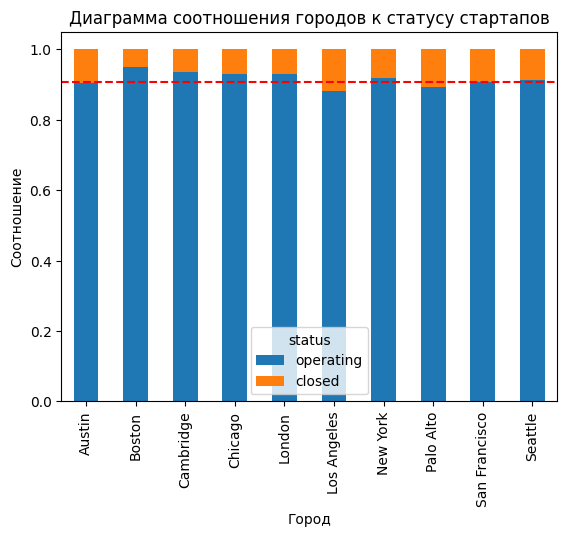

In [40]:
# Построим диаграмму соотношения стран (из числа TOP_COUNTRY по количеству стартапов в них) к статусам стартапов
df_tmp = df_train[df_train['city'].isin(
    df_train['city'].value_counts().head(10).
    index.to_list())]
pd.crosstab(
     [df_tmp['city']],
     df_tmp['status'],
     normalize = 'index').head(10)[['operating', 'closed']].plot.bar(stacked = True)
plt.title("Диаграмма соотношения городов к статусу стартапов")
plt.xlabel("Город")
plt.ylabel("Соотношение")
plt.axhline(mean_status, color='r', linestyle='--')
plt.show()

Большое количество городов (более 4 тыс.), чаще всего старпапы из Сан-Франциско (6%). Более 6 тыс. пропусков. Соотношение городов из ТОП-10 к статусу стартапов примерно одинаковое.

#### Количество раундов финансирования

In [41]:
df_train['funding_rounds'].describe()

count    52516.000000
mean         1.740670
std          1.374522
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         19.000000
Name: funding_rounds, dtype: float64

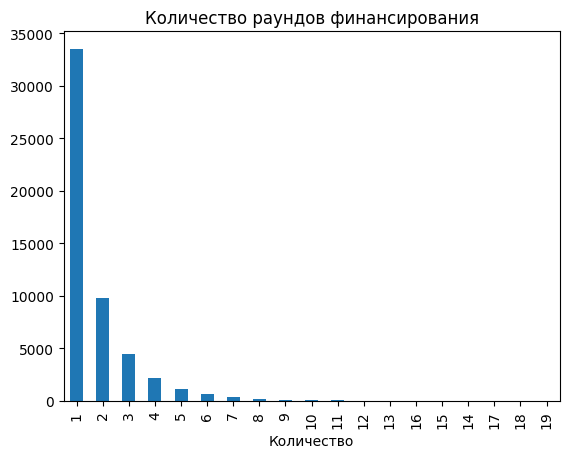

In [42]:
df_train['funding_rounds'].value_counts().plot(kind='bar')
plt.title("Количество раундов финансирования")
plt.xlabel('Количество')
plt.show()

In [43]:
df_train['funding_rounds'].value_counts(normalize=True)

funding_rounds
1     0.637691
2     0.186914
3     0.084736
4     0.041683
5     0.022241
6     0.011730
7     0.006493
8     0.003332
9     0.002076
10    0.001200
11    0.000876
12    0.000419
13    0.000171
16    0.000114
15    0.000095
14    0.000095
17    0.000057
18    0.000057
19    0.000019
Name: proportion, dtype: float64

Больше всего стартапов, у которых один раунд финансирования (63%)

#### Дата основания

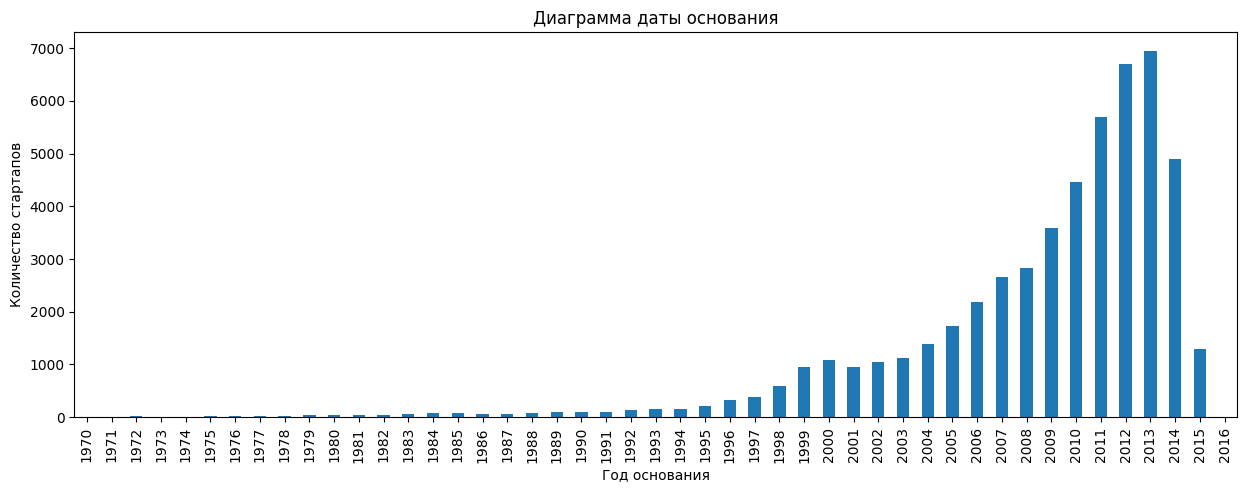

In [44]:
plt.figure(figsize=(15,5))
df_train["founded_at"].dt.year.value_counts().sort_index().plot(kind='bar')
plt.title("Диаграмма даты основания")
plt.xlabel('Год основания')
plt.ylabel('Количество стартапов')
plt.show()

Количество оснований компаний с каждым годом увеличивалось до 2013 года. Потом было резкое снижение.

#### Дата первого раунда финансирования

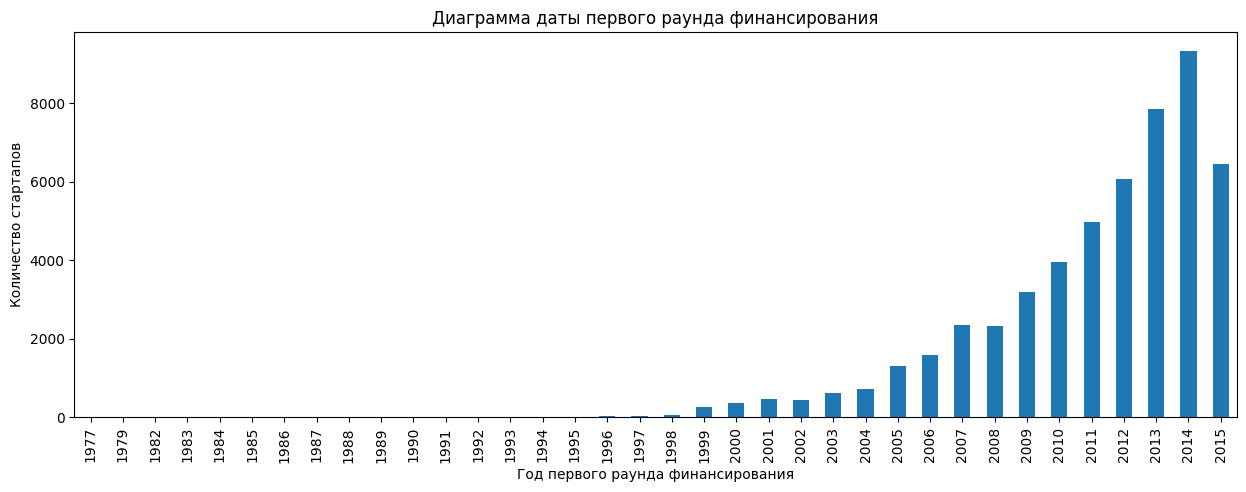

In [45]:
plt.figure(figsize=(15,5))
df_train["first_funding_at"].dt.year.value_counts().sort_index().plot(kind='bar')
plt.title("Диаграмма даты первого раунда финансирования")
plt.xlabel('Год первого раунда финансирования')
plt.ylabel('Количество стартапов')
plt.show()

Количество первых раундов финансирования увеличивалось с каждым годом до 2014 года. В 2015 году было снижение

#### Дата последнего раунда финансирования

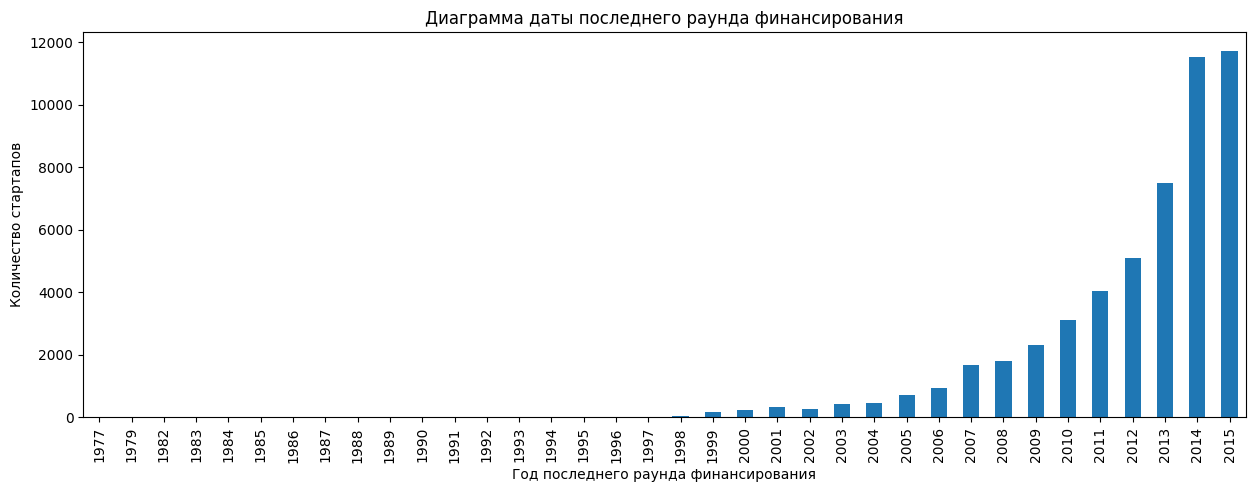

In [46]:
plt.figure(figsize=(15,5))
df_train["last_funding_at"].dt.year.value_counts().sort_index().plot(kind='bar')
plt.title("Диаграмма даты последнего раунда финансирования")
plt.xlabel('Год последнего раунда финансирования')
plt.ylabel('Количество стартапов')
plt.show()

Количество последних раундов финансирования увеличивалось с каждым годом до 2014 года. В 2015 количество осталось на том же уровне как в 2014 году.

#### Дата закрытия стартапа

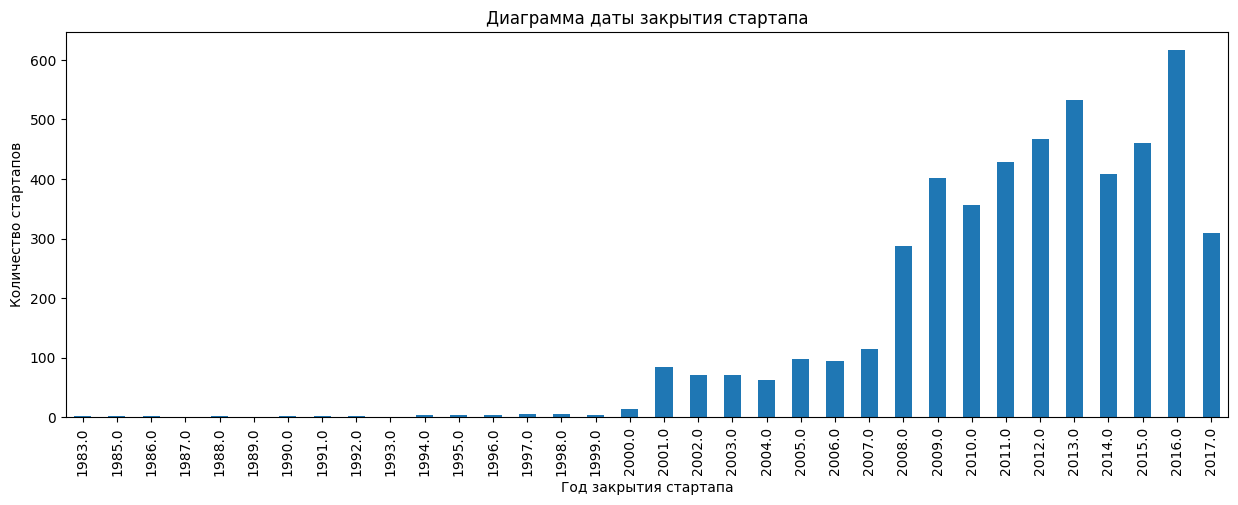

In [47]:
plt.figure(figsize=(15,5))
df_train["closed_at"].dt.year.value_counts().sort_index().plot(kind='bar')
plt.title("Диаграмма даты закрытия стартапа")
plt.xlabel('Год закрытия стартапа')
plt.ylabel('Количество стартапов')
plt.show()

Наибольшее количество закрытий стартапов было в 2016 году

In [48]:
df_train['closed_at'].isna().sum()

47599

In [49]:
df_train['status'].value_counts()

status
operating    47599
closed        4917
Name: count, dtype: int64

Количество пропусков у признака closed_at совпадает с количеством стартапов со статусом operating. Проверим, что дата закрытия есть только у стартапов со статусом closed.

In [50]:
df_train.loc[(df_train['status'] == 'closed') & (df_train['closed_at'].notna())].shape

(4917, 13)

Признак closed_at по сути повторяет признак status

В датафрейме чаще всего встречаются стартапы категории Software и Biotechnology. Стартапы категории 'Curated Web' чаще закрываются по сравнению со стартапами других категорий из ТОП-10. Общая сумма финансирования стартапов от 1 доллара до 30 млрд. долларов. Больше всего стартапов из США, а именно из штата Калифорния (вероятнее всего из Силиконовой долины). Больше всего стартапов, у которых один раунд финансирования (63%). Количество оснований компаний с каждым годом увеличивалось до 2013 года, так же как и даты первого и последнего раундов финансирования. Потом было резкое снижение. Наибольшее количество закрытий стартапов было в 2016 году

### Разработка новых синтетических признаков

Из признака category_list выделим ТОП-n признаков (значение n берем из TOP_CATEROGY)

In [51]:
# Создадим функцию, которая сначала разделеят категории по символу '|', потом считает сколько раз категория встречается в датасете
# затем выдает список категорий из ТОП
def get_top_category(top):
    category_dic = {}
    for category in df_train['category_list'].str.split('|').to_list():
        if category == 'nan':
            next
        for sub_cat in category:
            if sub_cat in category_dic:
                category_dic[sub_cat] += 1
            else:
                category_dic[sub_cat] = 1

    return pd.DataFrame(category_dic, index=['count']).T.sort_values(by='count', ascending=False).head(top).index

In [52]:
df_train['category_list'] = df_train['category_list'].astype(str)
df_train['category_list'] = df_train['category_list'].str.lower() 

In [53]:
top_categ = get_top_category(TOP_CATEROGY)

In [54]:
# Создадим функцию, которая будет для каждой категории из ТОП создавать отдельный признак
def category_to_feat(df_temp):
    for name_category in top_categ:
        df_temp[name_category] = df_temp['category_list'].str.contains(name_category)
        df_temp[name_category] = df_temp[name_category].apply(lambda x: 1 if x else 0)
    return df_temp

In [55]:
df_train = category_to_feat(df_train)

In [56]:
# Стартапы из России выделим в отдельный признак
top_cntr = ['RUS']

In [57]:
def country_to_feat(df_temp):
    for country in top_cntr:
        df_temp[country] = df_train['country_code'].apply(lambda x: 1 if x==country else 0)
    return df_temp

In [58]:
df_train = country_to_feat(df_train)

In [59]:
df_train.head(3)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,sales and marketing,hospitality,startups,sports,retail,financial services,design,fintech,web hosting,RUS
0,Lunchgate,online reservations|restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,...,0,0,0,0,0,0,0,0,0,0
1,EarLens,manufacturing|medical|medical devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,...,0,0,0,0,0,0,0,0,0,0
2,Reviva Pharmaceuticals,biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,...,0,0,0,0,0,0,0,0,0,0


In [60]:
# Переведем названия столбцов к змеиному коду ("snake_case")
df_train.columns = df_train.columns.str.lower().str.replace(' ', '_')

In [61]:
# Создадим новый признак года из признаков first_funding_at и last_funding_at
df_train['first_funding_year'] = df_train['first_funding_at'].dt.year
df_train['last_funding_year'] = df_train['last_funding_at'].dt.year

In [62]:
# Создадим новый признак месяца из признаков first_funding_at и last_funding_at
df_train['first_funding_month'] = df_train['first_funding_at'].dt.month
df_train['last_funding_month'] = df_train['last_funding_at'].dt.month

In [63]:
# Заменим "closed" на 1, "operating" на 0
df_train['status'] = df_train['status'].apply(lambda x: 1 if x=='closed' else 0)

In [64]:
# Создадим признак, который показывает разницу в днях между датами последнего и первого раунда финансирования
df_train['last_first'] = (df_train['last_funding_at'] - df_train['first_funding_at']).dt.days

In [65]:
# Пустые поля в признаке closed_at заполнил датой формирования выгрузки (2018-01-01).
# Это нужно для расчета времени существования стартапа
df_train['closed_at'].fillna(value='2018-01-01', inplace=True)

In [66]:
df_train['closed_at'].isnull().sum()

0

In [67]:
df_train['closed_at'] = pd.to_datetime(
    df_train['closed_at'], format='%Y-%m-%d')

In [68]:
# Создадим признак время существования стартапа
df_train['lifetime'] = (df_train['closed_at'] - df_train['founded_at']).dt.days

In [69]:
df_train['lifetime'].isnull().sum()

0

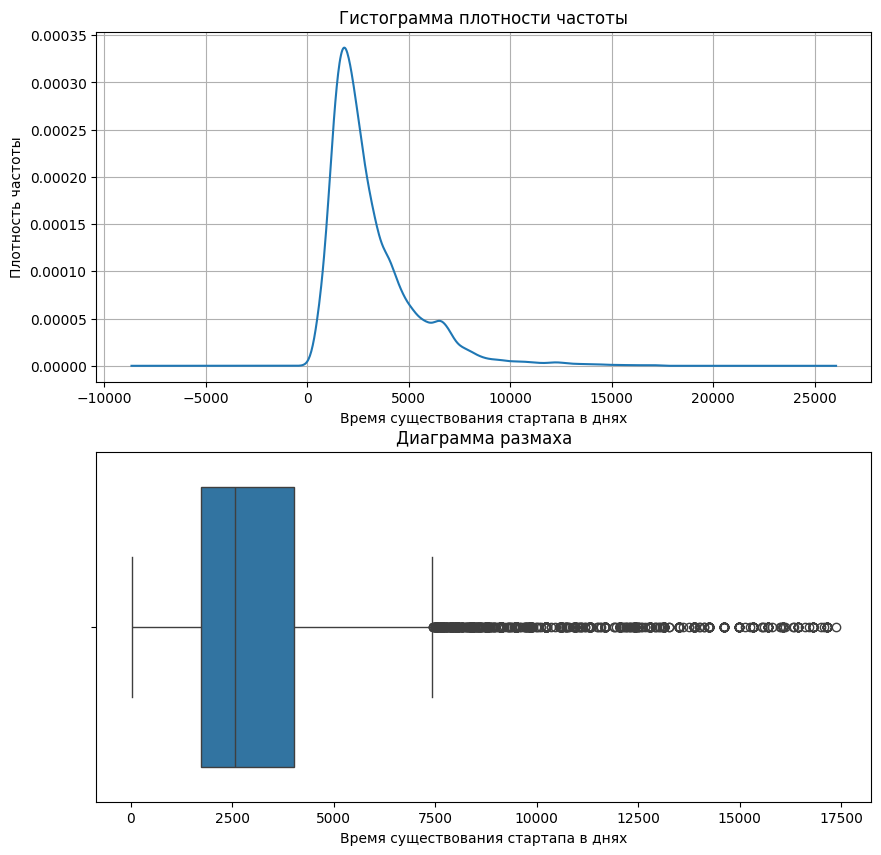

In [70]:
build_graph('lifetime', 'Время существования стартапа в днях')

In [71]:
df_train.shape

(52516, 70)

На этом этапе создали несколько новых признаков для модели:
- из признака category_list выделили ТОП-50 признаков;
- создали признаки с годами и месяцами первых и последних раундов финансирования;
- создали признак, который показывает разницу в днях между датами последнего и первого раунда финансирования;
- создали признак время существования стартапа

### Проверка на мультиколлинеарность

Будем использовать корреляцию Спирмена, т.к. в данных есть ненормальное распределение и выбросы

In [74]:
# Возьмем только числовые признаки (и без признаков-категорий)
num_features = ['status', 'funding_total_usd', 'funding_rounds', 'first_funding_year', 'last_funding_year',
                'first_funding_month', 'last_funding_month', 'last_first', 'lifetime']

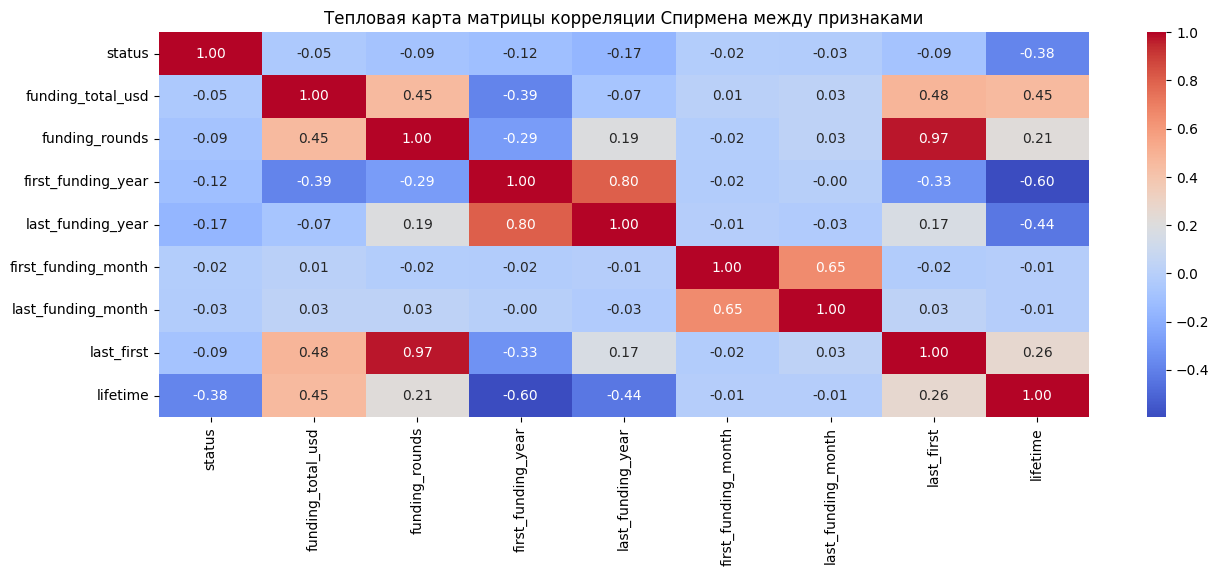

In [75]:
plt.figure(figsize=(15,5))
sns.heatmap(
    df_train[num_features].corr(method='spearman'), 
    cmap='coolwarm', 
    annot=True,
    fmt='.2f').set(title="Тепловая карта матрицы корреляции Спирмена между признаками")
plt.show()

Есть мультиколлинеарность между признаками 'funding_rounds' и 'last_first'. Из этих признаков для обучения модели выберем 'funding_rounds'

Используем библиотеку phik для подсчёта корреляции между признаками разных типов данных

In [76]:
interval_cols = ['funding_total_usd', 'funding_rounds', 'first_funding_year', 'last_funding_year',
                'first_funding_month', 'last_funding_month', 'lifetime']
features = interval_cols + ['status', 'country_code', 'state_code', 'region', 'city']

In [77]:
phik_overview = df_train[features].phik_matrix(interval_cols=interval_cols)

The number of unique values of variable city is large: 4477. Are you sure this is not an interval variable? Analysis for pairs of variables including city can be slow.
The number of unique values of variable region is large: 1036. Are you sure this is not an interval variable? Analysis for pairs of variables including region can be slow.


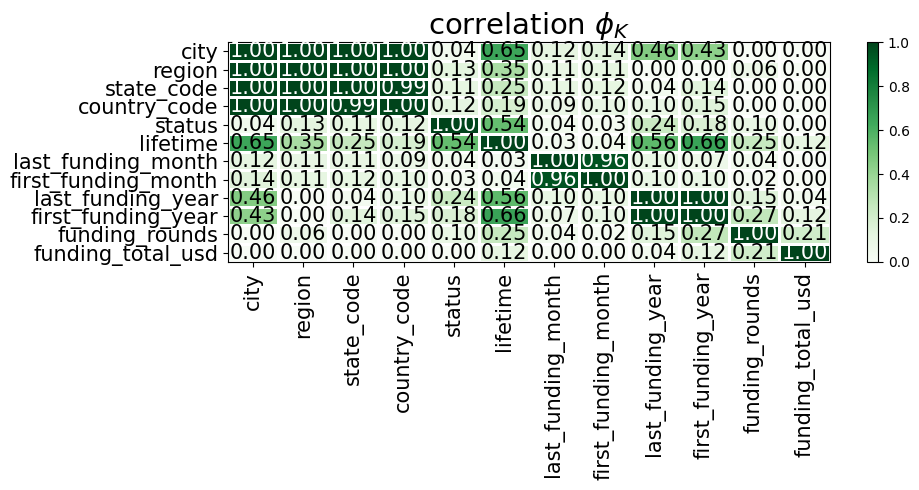

In [78]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(10, 5)
) 

Между признаками (city, region, state_code, country_code) есть мультиколлинеарность. Из этих признаков для обучения модели возьмем country_code, т.к. у него меньше пропусков.

Между признаками 'first_funding_month', 'last_funding_month' есть мультиколлинеарность. Из этих признаков для обучения модели возьмем 'last_funding_month', т.к. у него чуть выше коллинеарность с целевым признаком.

Между признаками 'first_funding_year', 'last_funding_year' есть мультиколлинеарность. Из этих признаков для обучения модели возьмем 'last_funding_year', т.к. у него выше коллинеарность с целевым признаком.

### Отбор финального набора обучающих признаков и подготовка данных для моделей

In [138]:
selected_features = df_train.columns.to_list()
del_features = [
    'name', 'category_list', 'status', 'region', 'state_code', 'city', 'country_code', 'last_first', 'first_funding_year',
    'founded_at', 'first_funding_at', 'last_funding_at', 'closed_at', 'first_funding_month'
]

In [139]:
for elem in del_features:
    selected_features.remove(elem)

In [140]:
num_columns = df_train[selected_features].select_dtypes(include='number').columns.tolist()
ohe_columns = df_train[selected_features].select_dtypes(include='object').columns.tolist()

In [141]:
df_train[selected_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 56 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   funding_total_usd       52516 non-null  float64
 1   funding_rounds          52516 non-null  int64  
 2   software                52516 non-null  int64  
 3   mobile                  52516 non-null  int64  
 4   biotechnology           52516 non-null  int64  
 5   e-commerce              52516 non-null  int64  
 6   nan                     52516 non-null  int64  
 7   curated_web             52516 non-null  int64  
 8   social_media            52516 non-null  int64  
 9   enterprise_software     52516 non-null  int64  
 10  advertising             52516 non-null  int64  
 11  health_care             52516 non-null  int64  
 12  games                   52516 non-null  int64  
 13  internet                52516 non-null  int64  
 14  saas                    52516 non-null

In [142]:
# Заполнение пропусков
df_train['funding_total_usd'] = df_train['funding_total_usd'].fillna(value=0)

In [143]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False, max_categories=15))
    ]
    )

In [144]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [145]:
X = df_train[selected_features]
y = df_train['status']

In [146]:
# Разделим данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, stratify=y)

In [147]:
print(X_train.shape)
print(X_test.shape)

(39387, 56)
(13129, 56)


In [148]:
X_train_prep = data_preprocessor.fit_transform(X_train)

In [149]:
features_names = data_preprocessor.get_feature_names_out()

In [150]:
features_names.shape

(56,)

In [151]:
X_test_prep = data_preprocessor.transform(X_test)

### Выбор и обучение моделей

In [152]:
cb_model = CatBoostClassifier(
            random_seed = RANDOM_STATE,
            eval_metric='F1',
            verbose=False
)

In [153]:
# Создадим словарь с гиперпараметрами:
cb_parameters = {
    'iterations': [1000, 1500, 2000],
    'learning_rate': [0.05, 0.1, 0.2],
    'depth': [4, 6, 8]
}

In [154]:
# Инициализируем класс для автоматизированного поиска:
# значение кросс-валидации 5 и n_jobs=-1.
cb_gs = GridSearchCV(cb_model, cb_parameters, cv=5, n_jobs=-1, scoring='f1')

In [155]:
# Запустим поиск гиперпараметров
%time cb_gs.fit(X_train_prep, y_train)

Wall time: 50min 6s


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001D173F23310>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 8], 'iterations': [1000, 1500, 2000],
                         'learning_rate': [0.05, 0.1, 0.2]},
             scoring='f1')

In [156]:
print("Лучшие гиперпараметры", cb_gs.best_params_)
print("Лучшая метрика по кросс-вадидации", cb_gs.best_score_)

Лучшие гиперпараметры {'depth': 8, 'iterations': 1500, 'learning_rate': 0.05}
Лучшая метрика по кросс-вадидации 0.8670512412578313


In [157]:
y_test_pred_cb = cb_gs.best_estimator_.predict(X_test_prep)
print(f'Метрика F1_score на тестовой выборке: {f1_score(y_test.to_list(), y_test_pred_cb)}')

Метрика F1_score на тестовой выборке: 0.8803156510302499


In [158]:
rfc_model = RandomForestClassifier(random_state=RANDOM_STATE)

In [159]:
# Создадим словарь с гиперпараметрами:
rfc_parameters = {
    'n_estimators': [150, 200, 250, 300],
    'max_depth': range(25,30)
}

In [160]:
# Инициализируем класс для автоматизированного поиска:
# значение кросс-валидации 5 и n_jobs=-1.
rfc_gs = GridSearchCV(rfc_model, rfc_parameters, cv=5, n_jobs=-1, scoring='f1')

In [161]:
# Запустим поиск гиперпараметров
%time rfc_gs.fit(X_train_prep, y_train)

Wall time: 11min 38s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=10), n_jobs=-1,
             param_grid={'max_depth': range(25, 30),
                         'n_estimators': [150, 200, 250, 300]},
             scoring='f1')

In [162]:
print("Лучшие гиперпараметры", rfc_gs.best_params_)
print("Лучшая метрика по кросс-вадидации", rfc_gs.best_score_)

Лучшие гиперпараметры {'max_depth': 29, 'n_estimators': 150}
Лучшая метрика по кросс-вадидации 0.8433068996224297


In [163]:
y_test_pred_rfc = rfc_gs.best_estimator_.predict(X_test_prep)
print(f'Метрика F1_score на тестовой выборке: {f1_score(y_test.to_list(), y_test_pred_rfc)}')

Метрика F1_score на тестовой выборке: 0.8625


### Итоговая оценка качества предсказания лучшей модели

Лучше получилась модель CatBoostClassifier

In [164]:
print("Точность на тестовой выборке у лучшей модели равна:", {f1_score(y_test.to_list(), y_test_pred_cb)})
print("Лучшие гиперпараметры", cb_gs.best_params_)

Точность на тестовой выборке у лучшей модели равна: {0.8803156510302499}
Лучшие гиперпараметры {'depth': 8, 'iterations': 1500, 'learning_rate': 0.05}


Обучим модель с лучшими гиперпараметрами на всех тренировочных данных

In [165]:
cb_model = CatBoostClassifier(
            random_seed = RANDOM_STATE,
            eval_metric='F1',
            verbose=False,
            depth=8, 
            iterations=1500, 
            learning_rate=0.05
)

In [166]:
X_prep = data_preprocessor.fit_transform(X)

In [167]:
features_names = data_preprocessor.get_feature_names_out()

In [168]:
cb_model.fit(X_prep, y)

Используя лучшую модель предскажем статус для стартапов из тестового набора с сайта

In [169]:
df_test = pd.read_csv('kaggle_startups_test_28062024.csv')

In [170]:
df_test.head(3)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295


In [171]:
df_test['first_funding_at'] = pd.to_datetime(
    df_test['first_funding_at'], format='%Y-%m-%d')

df_test['last_funding_at'] = pd.to_datetime(
    df_test['last_funding_at'], format='%Y-%m-%d')

In [172]:
df_test['first_funding_year'] = df_test['first_funding_at'].dt.year
df_test['last_funding_year'] = df_test['last_funding_at'].dt.year

In [173]:
df_test['first_funding_month'] = df_test['first_funding_at'].dt.month
df_test['last_funding_month'] = df_test['last_funding_at'].dt.month

In [174]:
df_test['last_first'] = (df_test['last_funding_at'] - df_test['first_funding_at']).dt.days

In [175]:
df_test['category_list'] = df_test['category_list'].astype(str)
df_test['category_list'] = df_test['category_list'].str.lower() 

In [176]:
df_test = category_to_feat(df_test)

In [177]:
df_test = country_to_feat(df_test)

In [178]:
# Переведем названия столбцов к змеиному коду ("snake_case")
df_test.columns = df_test.columns.str.lower().str.replace(' ', '_')

In [179]:
df_test.head(3)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,...,sales_and_marketing,hospitality,startups,sports,retail,financial_services,design,fintech,web_hosting,rus
0,Crystalsol,clean technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,...,0,0,0,0,0,0,0,0,0,0
1,JBI Fish & Wings,hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,...,0,1,0,0,0,0,0,0,0,0
2,COINPLUS,finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,...,0,0,0,0,0,0,0,0,0,0


In [180]:
df_test_prep = data_preprocessor.transform(df_test)

In [181]:
df_test['status'] = cb_model.predict(df_test_prep)

In [182]:
df_test['status'].value_counts()

status
0    12058
1     1067
Name: count, dtype: int64

In [183]:
# Заменим 1 на "closed", 0 на "operating"
df_test['status'] = df_test['status'].apply(lambda x: 'closed' if x==1 else 'operating')

In [184]:
df_test['status'].value_counts()

status
operating    12058
closed        1067
Name: count, dtype: int64

In [185]:
df_res = df_test[['name', 'status']]

In [186]:
df_res.to_csv('ver_15_6.csv', sep=',', index=False)

Public Score: 0.88675

Private Score: 0.89554

### Анализ важности ее признаков

Оценим важность признаков для каждой модели

In [187]:
cb_permutation = permutation_importance(cb_model, X_test_prep, y_test, scoring='f1', random_state=RANDOM_STATE)

In [195]:
pd.DataFrame(
    [cb_permutation.importances_mean], columns=features_names
    ).T.rename(
            columns={0: 'значение_важности'}
            ).sort_values(by='значение_важности', ascending=False).head()

,значение_важности
num__lifetime,0.702851
num__last_funding_year,0.443439
num__last_funding_month,0.024824
num__funding_rounds,0.023321
num__funding_total_usd,0.022622


Самыми важными признаками получились "Время существования стартапа в днях" и "Год последнего раунда финансирования"

In [189]:
rfc_permutation = permutation_importance(rfc_gs.best_estimator_, X_test_prep, y_test, scoring='f1', random_state=RANDOM_STATE)

In [196]:
pd.DataFrame(
    [rfc_permutation.importances_mean], columns=features_names
    ).T.rename(
            columns={0: 'значение_важности'}
            ).sort_values(by='значение_важности', ascending=False).head()

,значение_важности
num__lifetime,0.673776
num__last_funding_year,0.338047
num__funding_total_usd,0.009810
num__funding_rounds,0.008032
num__last_funding_month,0.007350


Самыми важными признаками тоже получились "Время существования стартапа в днях" и "Год последнего раунда финансирования"

#### Оценим и построим важность признаков с помощью метода SHAP

In [191]:
cb_explainer = shap.TreeExplainer(cb_model)

In [192]:
shap_values = cb_explainer(pd.DataFrame(X_test_prep, columns=features_names))

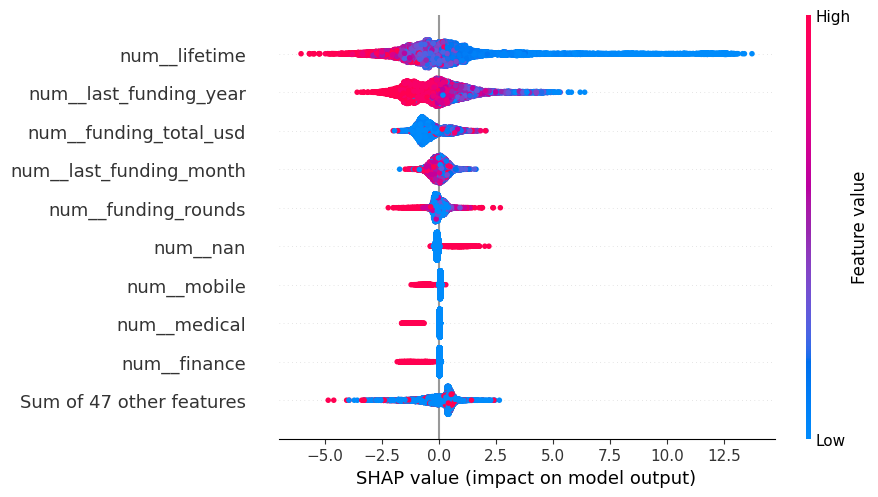

In [193]:
shap.plots.beeswarm(shap_values)

По графику Шепли видно, что чем выше значения признаков lifetime (Время существования стартапа), last_funding_year (Год последнего раунда финансирования), тем выше вероятность статуса стартапа 0 (opening), т.е. выше вероятность успешности стартапа.

Если стартап относится к категорям mobile и enterprise_software, то у него выше вероятность успешности.

### Отчет по исследованию

При выполнении задачи было сделано:
- загрузили и ознакомились с данными о 52516 стартапов. В данных много пропусков, у некоторых признаков более 10% пропусков;
- предварительно обработали данные. У некоторых признаков поменяли тип данных;
- полноценный разведочный анализ. В датафрейме чаще всего встречаются стартапы категории Software и Biotechnology. Больше всего стартапов из США. Больше всего стартапов, у которых один раунд финансирования (63%). Количество оснований компаний с каждым годом увеличивалось до 2013 года. Потом было резкое снижение. Наибольшее количество закрытий стартапов было в 2016 году
- разработали новые синтетические признаки. Из признака category_list выделили ТОП-50 признаков. Создали признаки с годами и месяцами первых и последних раундов финансирования. Создали признак, который показывает разницу в днях между датами последнего и первого раунда финансирования. Создали признак время существования стартапа
- проверили признаки на мультиколлинеарность. Для этого использовали корреляцию Спирмена и библиотеку phik (для расчета корреляции между признаками разных типов данных). Между некоторыми признаками выявили мультиколлинеарность;
- с учетом выявленной мультиколлинеарности выбрали финальный набор обучающих признаков и подготовили данные для моделей
- провели обучение моделей CatBoostClassifier и RandomForestClassifier с подбором гиперпараметров. Точность предсказания получилась у модели CatBoostClassifier;
- используя лучшую модель предсказали статус для стартапов из тестового набора;
- оценили важность признаков. Самыми важными признаками для предсказания успешности стартапа являются "Время существования стартапа в днях" и "Год последнего раунда финансирования" и чем выше значения этих признаков, тем выше вероятность успешности стартапа. Кроме того, если стартап относится к категорям mobile и enterprise_software, то у него выше вероятность успешности.
